In [7]:
#https://www.relataly.com/univariate-stock-market-forecasting-using-a-recurrent-neural-network/122/
#https://www.relataly.com/changing-prediction-intervals-for-time-series-forecasting-models/169/

#https://www.relataly.com/regression-error-metrics-python/923/
#https://github.com/flo7up/relataly-public-python-tutorials/blob/master/009%20Time%20Series%20Forecasting%20-%20Measuring%20Model%20Performance.ipynb

import math 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # For analysing and manipulating data
from datetime import date, timedelta,datetime # Date Functions
import matplotlib.pyplot as plt # For visualization
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # For measuring model performance / errors
from sklearn.preprocessing import MinMaxScaler ,RobustScaler #to normalize the price data 
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
import seaborn as sns

# Step #1 Load the Data

In [31]:
ab_path = "../data/SPY-Daily-Y09-Now.csv"
stockname='S&P500'
start_date='2016-01-01'
end_date='2022-12-31'

prediction_col='MACD'
sequence_length = 60
train_ratio=0.8

split_way=2

epochs=100
batch_size=32

n_early=0

In [9]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':'Date'},inplace=True)
allCols=list(df.columns)
print(allCols)

df['Date']=df['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index('Date',inplace=True)
df=df.loc[start_date:end_date,:]
print(df.info())
df.tail()

['Ticker', 'Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2016-01-04 to 2022-12-29
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1761 non-null   object 
 1   Price   1761 non-null   float64
 2   EMA1    1761 non-null   float64
 3   EMA2    1761 non-null   float64
 4   EMA3    1761 non-null   float64
 5   MACD    1761 non-null   float64
 6   SIGNAL  1761 non-null   float64
 7   RSI     1761 non-null   float64
 8   RSI-MA  1761 non-null   float64
dtypes: float64(8), object(1)
memory usage: 137.6+ KB
None


,Ticker,Price,EMA1,EMA2,EMA3,MACD,SIGNAL,RSI,RSI-MA
Date,,,,,,,,,
2022-12-22,SPY,380.72,387.58,390.58,390.58,-2.99,0.37,41.81,41.92
2022-12-23,SPY,382.91,386.73,389.85,389.85,-3.11,-0.07,43.83,42.30
2022-12-27,SPY,381.40,385.76,389.04,389.04,-3.28,-0.47,42.73,42.88
2022-12-28,SPY,376.66,384.11,387.86,387.86,-3.75,-0.88,39.42,42.69
2022-12-29,SPY,383.44,383.99,387.44,387.44,-3.45,-1.20,45.85,42.73


# Step #2 Explore the Data

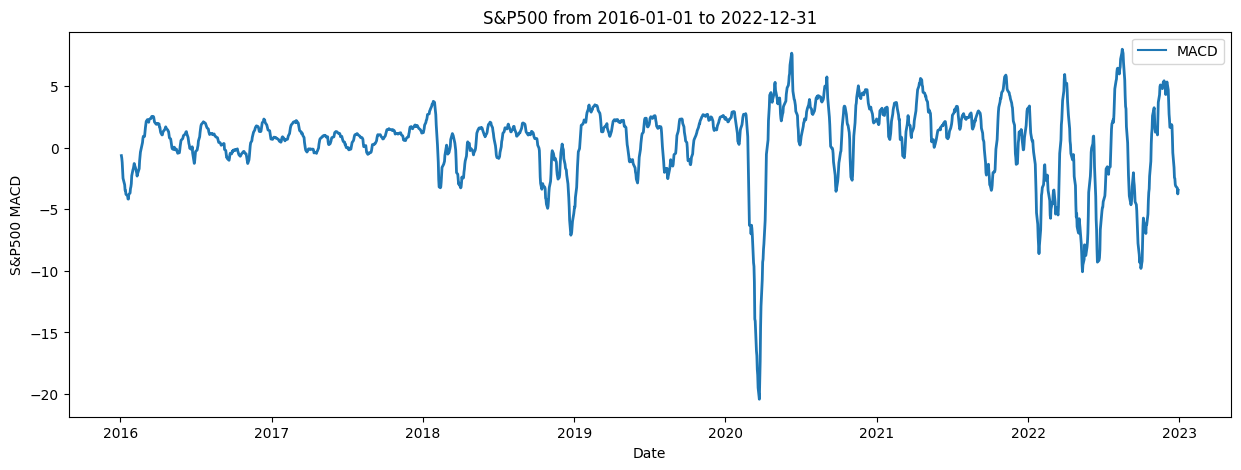

In [12]:
# Creating a Lineplot
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.xaxis.set_major_locator(years)

plt.title(stockname + ' from '+ start_date + ' to ' + end_date)
sns.lineplot(data=df[[prediction_col]], linewidth=2.0)
plt.ylabel(f'{stockname} {prediction_col}')
plt.show()

# Step #3-4 Creating the Input Shape  and Scale Data

In [13]:

# Feature Selection - Only Close Data
train_df = df.filter([prediction_col])
data_unscaled = train_df.values
print(data_unscaled.shape)
print(data_unscaled[:5])




(1761, 1)
[[-0.64]
 [-0.84]
 [-1.19]
 [-1.84]
 [-2.48]]


In [14]:

train_data_length = math.ceil(len(data_unscaled) *train_ratio )
print("Total train data : "+str(train_data_length))

# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_unscaled.shape[0] * train_ratio)
print(f"Apply total train {train_data_len}  to look back {sequence_length} prev day to predict")

# Set the sequence length - this is the timeframe used to make a single prediction
# train_data_len - sequence_length is take the first 50 data to predict test

the_first_m_data_to_predict_to_predict_the_first_test=train_data_len - sequence_length
print(f"First M Date to Predict First Test = {the_first_m_data_to_predict_to_predict_the_first_test}")

# Prediction Index
index_Close = train_df.columns.get_loc(prediction_col)
print(f"Prediction Index : {index_Close}")
# Split the training data into train and train data sets


Total train data : 1409
Apply total train 1409  to look back 60 prev day to predict
First M Date to Predict First Test = 1349
Prediction Index : 0


In [15]:
# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
# mmscaler= RobustScaler()



if split_way==1:
    print("Way#1 scale entire data and split data")
    np_data = mmscaler.fit_transform(data_unscaled)
    print(np_data.shape)
    print(np_data[:5])
    
    train_data = np_data[0:train_data_len, :]
    test_data = np_data[the_first_m_data_to_predict_to_predict_the_first_test:, :]


else:
    print("#Way#2 split data and apply  only train to scale")
    train_data = data_unscaled[0:train_data_len, :]
    test_data = data_unscaled[the_first_m_data_to_predict_to_predict_the_first_test:, :]
    
    train_data=mmscaler.fit_transform(train_data)
    test_data=mmscaler.transform(test_data)

print("Data")
print(train_data.shape)
print(test_data.shape)
print(train_data[:3])
print(test_data[:3])

#Way#2 split data and apply  only train to scale
Data
(1409, 1)
(412, 1)
[[0.70391459]
 [0.69679715]
 [0.68434164]]
[[0.74377224]
 [0.74982206]
 [0.75017794]]


In [16]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(train_df[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# print(x_test[1][sequence_length-1][index_Close])
# print(y_test[0])

print("X")
print(x_train[:2])
print("Y")
print(y_train[:2])

(1349, 60, 1) (1349,)
(352, 60, 1) (352,)
X
[[[0.70391459]
  [0.69679715]
  [0.68434164]
  [0.66120996]
  [0.63843416]
  [0.62384342]
  [0.61957295]
  [0.60355872]
  [0.60320285]
  [0.59217082]
  [0.58754448]
  [0.57864769]
  [0.57829181]
  [0.59217082]
  [0.59572954]
  [0.6088968 ]
  [0.613879  ]
  [0.6227758 ]
  [0.6455516 ]
  [0.6633452 ]
  [0.66690391]
  [0.67402135]
  [0.68113879]
  [0.67615658]
  [0.66548043]
  [0.65836299]
  [0.65409253]
  [0.64483986]
  [0.65088968]
  [0.66619217]
  [0.68825623]
  [0.70284698]
  [0.713879  ]
  [0.73060498]
  [0.73558719]
  [0.74163701]
  [0.75338078]
  [0.75978648]
  [0.7594306 ]
  [0.77259786]
  [0.78434164]
  [0.79466192]
  [0.80284698]
  [0.80818505]
  [0.80391459]
  [0.8024911 ]
  [0.80035587]
  [0.80782918]
  [0.81103203]
  [0.81067616]
  [0.81281139]
  [0.81672598]
  [0.81743772]
  [0.81708185]
  [0.81530249]
  [0.80782918]
  [0.80106762]
  [0.79466192]
  [0.79501779]
  [0.79644128]]

 [[0.69679715]
  [0.68434164]
  [0.66120996]
  [0.6384

# Step #5 Designing the Model Architecture 

In [32]:
tf.random.set_seed(7)

# Configure the neural network model
model = Sequential()


neurons = sequence_length
print(f"Train Row :{x_train.shape[0]}")
print(f"neurons=sequence_length={sequence_length}")

# Way#1  1 lstm 
model.add(LSTM(neurons, input_shape=(x_train.shape[1], 1))) 

# Way#2 serveral lstm with sequence_length Neurons  (require  return_sequences=True)
# # inputshape = sequence_length Timestamps
# model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1],  x_train.shape[2]))) 
# model.add(LSTM(neurons, return_sequences=False))


model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

Train Row :1349
neurons=sequence_length=60


# Step #6 Train the Univariate Model

In [18]:
if n_early>0:
 print(f"Training the model with Early Stop {n_early} epoch={epochs}  batch_size={batch_size}")   
 callback = EarlyStopping(monitor='loss', patience=n_early)
 model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size, shuffle=False,verbose=2,callbacks=[callback])
else:
  print(f"Training the model epoch={epochs}  batch_size={batch_size}")
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,shuffle=False,verbose=2)

Training the model epoch=100  batch_size=32
Epoch 1/100
43/43 - 6s - loss: 0.0335 - 6s/epoch - 142ms/step
Epoch 2/100
43/43 - 2s - loss: 0.0029 - 2s/epoch - 38ms/step
Epoch 3/100
43/43 - 1s - loss: 0.0027 - 1s/epoch - 33ms/step
Epoch 4/100
43/43 - 1s - loss: 0.0025 - 1s/epoch - 33ms/step
Epoch 5/100
43/43 - 1s - loss: 0.0023 - 1s/epoch - 35ms/step
Epoch 6/100
43/43 - 1s - loss: 0.0021 - 1s/epoch - 32ms/step
Epoch 7/100
43/43 - 1s - loss: 0.0019 - 1s/epoch - 31ms/step
Epoch 8/100
43/43 - 1s - loss: 0.0018 - 1s/epoch - 32ms/step
Epoch 9/100
43/43 - 2s - loss: 0.0016 - 2s/epoch - 35ms/step
Epoch 10/100
43/43 - 1s - loss: 0.0015 - 1s/epoch - 34ms/step
Epoch 11/100
43/43 - 1s - loss: 0.0014 - 1s/epoch - 32ms/step
Epoch 12/100
43/43 - 2s - loss: 0.0013 - 2s/epoch - 41ms/step
Epoch 13/100
43/43 - 2s - loss: 0.0012 - 2s/epoch - 39ms/step
Epoch 14/100
43/43 - 2s - loss: 0.0012 - 2s/epoch - 42ms/step
Epoch 15/100
43/43 - 2s - loss: 0.0011 - 2s/epoch - 39ms/step
Epoch 16/100
43/43 - 2s - loss: 0.

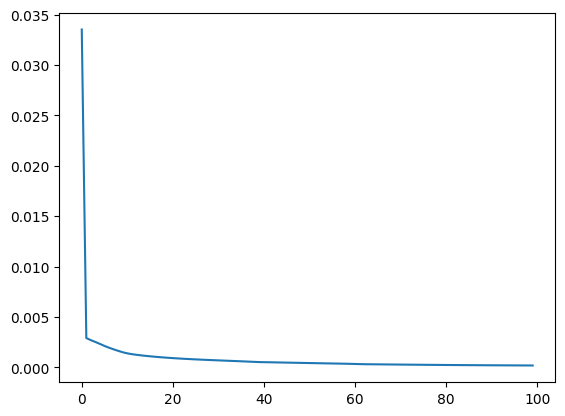

In [19]:
# plot history
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# Step #7 Make Predictions

In [20]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred_scaled[:2]
print(y_pred_scaled.shape)



11/11 [==============================] - 1s 11ms/step
(352, 1)


In [21]:
y_pred = mmscaler.inverse_transform(y_pred_scaled)
y_test_unscaled = mmscaler.inverse_transform(y_test.reshape(-1, 1))
print(y_pred.shape)
print(y_pred[:3])

print(y_test_unscaled.shape)
print(y_test_unscaled[:3])

(352, 1)
[[2.6220067]
 [2.6493626]
 [2.5889728]]
(352, 1)
[[2.45]
 [2.44]
 [2.49]]


# Step #8 Evaluate Model Performance

In [23]:

RMSE =math.sqrt (mean_squared_error(y_test_unscaled,y_pred ))
print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 10)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')


# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')




Root MEAN Square Error(RMSE): 0.7124502642
Mean Absolute Error (MAE): 0.55
Mean Absolute Percentage Error (MAPE): 44.7 %
Median Absolute Percentage Error (MDAPE): 12.86 %


In [24]:
train = pd.DataFrame(train_df[:train_data_length + 1]).rename(columns={prediction_col: 'x_train'})
print(train.head())
print(train.tail())

# Add the difference between the valid and predicted prices
train = pd.DataFrame(train_df[:train_data_length + 1]).rename(columns={prediction_col: 'y_train'})
valid = pd.DataFrame(train_df[train_data_length:]).rename(columns={prediction_col: 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

print(df_union.tail())

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > '2020-01-01']
print(df_union_zoom.head())


            x_train
Date               
2016-01-04    -0.64
2016-01-05    -0.84
2016-01-06    -1.19
2016-01-07    -1.84
2016-01-08    -2.48
            x_train
Date               
2021-08-03     2.47
2021-08-04     2.30
2021-08-05     2.38
2021-08-06     2.46
2021-08-09     2.45
            y_train  y_test  residuals    y_pred
Date                                            
2022-12-22      NaN   -2.99   0.276380 -2.713620
2022-12-23      NaN   -3.11   0.438068 -2.671932
2022-12-27      NaN   -3.28   0.362532 -2.917468
2022-12-28      NaN   -3.75   0.497496 -3.252504
2022-12-29      NaN   -3.45  -0.275499 -3.725499
            y_train  y_test  residuals  y_pred
Date                                          
2020-01-02     2.45     NaN        NaN     NaN
2020-01-03     2.30     NaN        NaN     NaN
2020-01-06     2.25     NaN        NaN     NaN
2020-01-07     2.10     NaN        NaN     NaN
2020-01-08     2.10     NaN        NaN     NaN


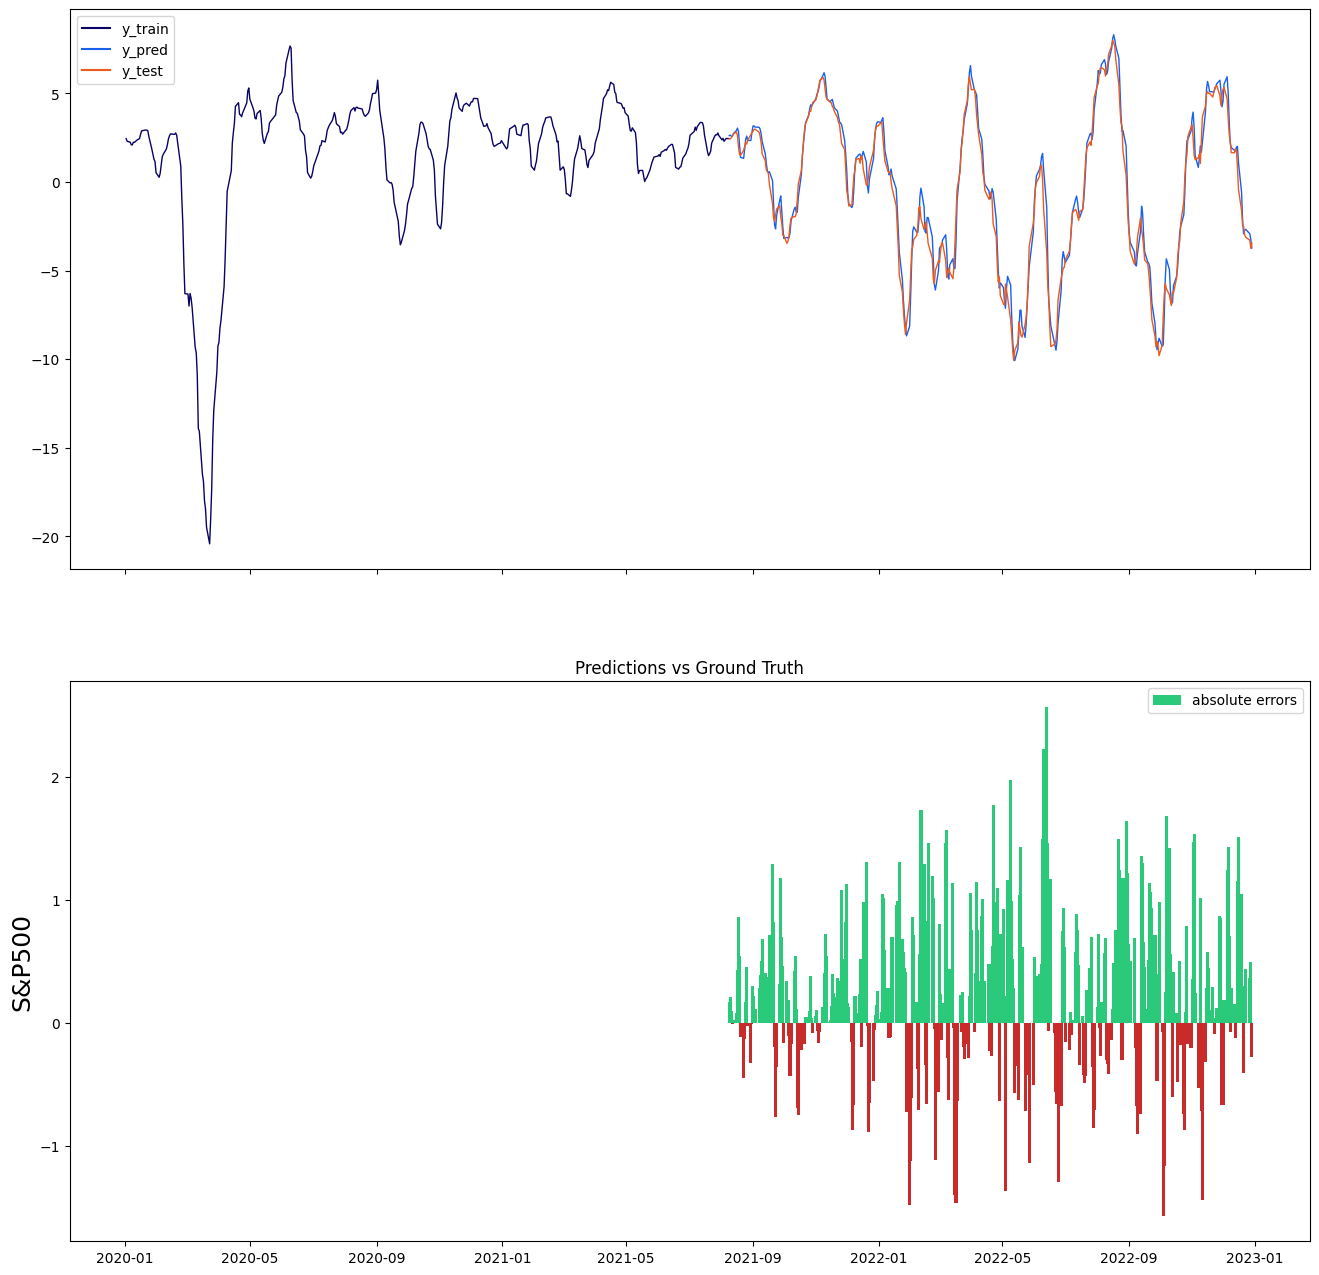

In [25]:
# Create the lineplot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), sharex=True)
plt.title("Predictions vs Ground Truth")
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
plt.ylabel(stockname, fontsize=18)
sns.lineplot(data=df_union_zoom[['y_train', 'y_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the barplot for the absolute errors
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax2.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)


plt.legend()
plt.show()

# Step #9 Get the last  {sequence_length} to Predict Next Day's Price

In [26]:
print(f"Get the last  {sequence_length} days to Predict Next Day's Price")
print("Transforn scale the data to be values between 0 and 1")
# Get fresh data
df_new = df.filter([prediction_col])
df_new_values=d=df_new[-sequence_length:].values
print(df_new_values.shape)
print(df_new_values[:3])

last_days_scaled = mmscaler.transform(df_new_values)


Get the last  60 days to Predict Next Day's Price
Transforn scale the data to be values between 0 and 1
(60, 1)
[[-6.39]
 [-5.71]
 [-6.01]]


In [27]:
print(f"Create an empty list and Append past {sequence_length} days")
X_test = []
X_test.append(last_days_scaled)


print("Convert the X_test data set to a numpy array and reshape the data")
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)


Create an empty list and Append past 60 days
Convert the X_test data set to a numpy array and reshape the data
(1, 60, 1)


In [28]:
# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model.predict(X_test)

pred_price_unscaled = mmscaler.inverse_transform(pred_price)

print(pred_price_unscaled)

1/1 [==============================] - 1s 910ms/step
[[-3.5594368]]


In [29]:
# Print last price and predicted price for the next day
price_today = round(df_new[prediction_col][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
print(predicted_price)

-3.56


In [30]:
percent_change = round((predicted_price * 100)/price_today - 100, 2)

prefix = '+' if percent_change > 0 else ''
print(f'The close price for {stockname} at {datetime.today} was {price_today}')
print(f'The predicted close price for the next day is {predicted_price} ({prefix}{percent_change}%)')

The close price for S&P500 at <built-in method today of type object at 0x00007FFAE358D650> was -3.45
The predicted close price for the next day is -3.559999942779541 (+3.19%)
